<a href="https://colab.research.google.com/github/19G12/DL_scratch/blob/main/FCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Day 1**

*   Load and normalize MNIST Data
*   Linear with He initialization (weights from gaussian dist)
*   Implement ReLU
*   Chain 2 levels with RELU and do a forward pass

In [ ]:
import os
import urllib.request
import numpy as np
import gzip
import pandas as pd

In [ ]:
# We already have train and test split data

mnist_test = pd.read_csv('/content/sample_data/mnist_test.csv')
mnist_train = pd.read_csv('/content/sample_data/mnist_train_small.csv')

Y_train = mnist_train.iloc[:, 0].to_numpy()
X_train = mnist_train.iloc[:, 1:].to_numpy().reshape(-1, 28*28)/255

Y_test = mnist_test.iloc[:, 0].to_numpy()
X_test = mnist_test.iloc[:, 1:].to_numpy().reshape(-1, 28*28)/255

In [ ]:
print("Train shape:", X_train.shape, Y_train.shape)
print("Test shape:", X_test.shape, Y_test.shape)

Train shape: (19999, 784) (19999,)
Test shape: (9999, 784) (9999,)


In [ ]:
## Linear Layer with He initialization

class LinearLayer:

  def __init__(self, input_dim, output_dim):
    self.W = np.random.randn(input_dim, output_dim) * np.sqrt(2. /input_dim)
    self.b = np.zeros((1, output_dim))
    self.dW = 0
    self.db = 0

  def forward(self, X):
    self.X = X
    return np.dot(X, self.W) + self.b # Numpy broadcasting

  # Day2
  def backward(self, dL_dY):
    self.dW = np.dot(self.X.T, dL_dY)
    self.db = np.sum(dL_dY, axis=0, keepdims=True)
    return np.dot(dL_dY, self.W.T) # This is h(k-1) layer

In [ ]:
## RelU activation

class ReLU:

  def forward(self,X):
    self.mask = X>0
    return X*self.mask

  # Day2
  def backward(self, grad_output):
    return self.mask * grad_output

In [ ]:
## LeakyRelu activation

class LeakyRelU:

  def forward(self, X):
    self.mask = X>0
    return X*np.where(self.mask, 1, 0.01)

  # Day2
  def backward(self, grad_output):
    return grad_output * np.where(self.mask, 1, 0.01)

In [ ]:
## Compute safe softmax and cross entropy loss, from logits input - Day2

def softmax_cross_entropy_loss(logits, labels):

  exp = np.exp(logits - np.max(logits, axis=1, keepdims=True))
  softmax = exp / np.sum(exp, axis=1, keepdims=True)

  batch_size = logits.shape[0]
  correct_logprobs = -np.log(softmax[np.arange(batch_size), labels] + 1e-9)
  loss = np.sum(correct_logprobs) / batch_size
  return softmax, loss

In [ ]:
## Gradients of loss at output layer - Day2

def softmax_cross_entropy_loss_backward(softmax_probs, labels):

  batch_size = softmax_probs.shape[0]
  grad = softmax_probs.copy()
  grad[np.arange(batch_size), labels] -= 1
  grad /= batch_size
  return grad

In [ ]:
## Make a dummy network 3 layer deep

layer1 = LinearLayer(784,128)
relu1 = ReLU()
layer2 = LinearLayer(128, 64)
relu2 = ReLU()
layer3 = LinearLayer(64, 10)

def forward_pass(x):
  layer1_out = layer1.forward(x)
  relu1_out = relu1.forward(layer1_out)
  layer2_out = layer2.forward(relu1_out)
  relu2_out = relu2.forward(layer2_out)
  layer3_out = layer3.forward(relu2_out)
  return layer3_out


In [ ]:
## Make a minibatch and pass

X_batch = X_train[:5]
Y_batch = Y_train[:5]

out = forward_pass(X_batch)
print("Output shape: ", out.shape)
print("Output logits: ", out)

Output shape:  (5, 10)
Output logits:  [[ 0.27687057 -0.6981354  -0.66782025 -0.14167052  0.62019475  0.32296846
  -0.70735487 -0.43305741 -0.39987477 -0.3719002 ]
 [-0.29078071 -0.7938101  -0.63673306  0.03034183 -0.33481601  0.73639029
  -0.11591442 -0.53626534 -0.97250719  0.60936038]
 [ 0.04149395 -0.38661013 -0.6404815  -0.10705742 -0.49497382  0.33926206
  -0.74186933 -0.45792528 -0.75038952  0.13025264]
 [ 0.18981326 -0.30410043 -0.31195133 -0.17597901  0.00403582  0.00217031
  -0.3087758  -0.14603987 -0.31820903 -0.2874532 ]
 [-0.14529557 -0.25184454 -0.77338255  0.12671598 -0.23811856 -0.62026095
  -0.42113235 -0.48517241 -0.60102408  0.20466321]]


## **Day 2**

1.   Implement forward pass
2.   Implement cross_entropy loss
3.   Implement backpropagation
4.   Prepare for weight updates

In [ ]:
## Forward propagation
## The above changes has been made to the earlier code itself

X_batch = X_train[:5]
Y_batch = Y_train[:5]

out = forward_pass(X_batch)
probs, loss1 = softmax_cross_entropy_loss(out, Y_batch)

In [ ]:
# Back-tracking
softmax_grad = softmax_cross_entropy_loss_backward(probs, Y_batch)
grad = layer3.backward(softmax_grad)
grad = relu2.backward(grad)
grad = layer2.backward(grad)
grad = relu1.backward(grad)
fin_grad = layer1.backward(grad)

# Update all layer weights with simple GD
learning_rate = 0.01
layer1.W -= learning_rate * layer1.dW
layer1.b -= learning_rate * layer1.db

layer2.W -= learning_rate * layer2.dW
layer2.b -= learning_rate * layer2.db

layer3.W -= learning_rate * layer3.dW
layer3.b -= learning_rate * layer3.db

In [ ]:
out = forward_pass(X_batch)
probs, loss2 = softmax_cross_entropy_loss(out, Y_batch)

/tmp/ipython-input-30-801773364.py:9: RuntimeWarning: divide by zero encountered in log
  correct_logprobs = -np.log(softmax[np.arange(batch_size), labels])


In [ ]:
print(f"Loss before update: {loss1}")
print(f"Loss after update: {loss2}")

Loss before update: 2.303174376519629
Loss after update: inf


## **Day 3**


1.   Implement Adam optimizer
2.   Add Dropout
3.   Implement one train epoch
4.   Evaluate accuracy



In [ ]:
class SGD_momentum:

  def __init__(self, params, learning_rate=0.01):
    self.params = params
    self.lr = learning_rate
    self.momentum = [np.zeros_like(p) for p,_ in params]

  def iterate(self):

    for i, (p, grad) in enumerate(self.params):

      self.momentum[i] = 0.9 * self.momentum[i] + (1 - 0.9) * grad
      p[...] -= self.lr * self.momentum[i]

In [ ]:
class Dropout:

  def __init__(self, p, training=True):
    self.p = p
    self.mask = None
    self.training = training

  def forward(self, x):
    if not self.training:
      return x
    self.mask = (np.random.randn(*x.shape) > self.p)/(1 - self.p)
    return x*self.mask

  def backward(self, grad):
    return grad*self.mask

In [ ]:
dropout1 = Dropout(0.0)
dropout2 = Dropout(0.0)

def forward_with_dropout(x):

  layer1_out = layer1.forward(x)
  relu1_out = relu1.forward(layer1_out)
  dropout1_out = dropout1.forward(relu1_out)

  layer2_out = layer2.forward(dropout1_out)
  relu2_out = relu2.forward(layer2_out)
  dropout2_out = dropout2.forward(relu2_out)

  layer3_out = layer3.forward(dropout2_out)
  return layer3_out

In [ ]:
## Initalize adam optimizer

sgdm = SGD_momentum(params = [(layer1.W, layer1.dW), (layer1.b, layer1.db),
                               (layer2.W, layer2.dW), (layer2.b, layer2.db),
                               (layer3.W, layer3.dW), (layer3.b, layer3.db)])

In [ ]:
## Epoch wise training loop

num_epochs = 15
batch_size = 32

for epoch in range(num_epochs):

  total_loss = 0
  total_samples = 0

  for i in range(0, len(X_train), batch_size):
    X_batch = X_train[i:i+batch_size]
    Y_batch = Y_train[i:i+batch_size]

    # Forward pass
    out = forward_with_dropout(X_batch)
    probs, loss = softmax_cross_entropy_loss(out, Y_batch)

    # Sanity check
    print("Logits:", out[0])
    print("Softmax:", probs[0])
    print("Predicted Label:", np.argmax(probs[0]))
    print("True Label:", Y_batch[0])

    total_loss += loss * X_batch.shape[0]   # un-average the loss
    total_samples += X_batch.shape[0]

    # Backward pass
    softmax_grad = softmax_cross_entropy_loss_backward(probs, Y_batch)
    grad = layer3.backward(softmax_grad)
    grad = dropout2.backward(grad, True)
    grad = relu2.backward(grad)
    grad = layer2.backward(grad)
    grad = dropout1.backward(grad, True)
    grad = relu1.backward(grad)
    grad = layer1.backward(grad)

    sgdm.iterate()

    print(layer1.W.__array_interface__['data'][0])
    print(sgdm.params[0][0].__array_interface__['data'][0])

  avg_loss = total_loss / total_samples


## **Day 4**

1.   Create validation instance
2.   Forward without dropout


In [ ]:
## Implement forward without dropout

def forward_without_dropout(x):
  layer1_out = layer1.forward(x)
  relu1_out = relu1.forward(layer1_out)
  layer2_out = layer2.forward(relu1_out)
  relu2_out = relu2.forward(layer2_out)
  layer3_out = layer3.forward(relu2_out)
  return layer3_out

In [ ]:
## Evaluate validation loss

def evaluate_validation_loss(X_val, Y_val, batch_size = 32):

  total_loss = 0
  total_samples = 0

  for i in range(0,len(X_val),batch_size):

    X_batch = X_val[i:i+batch_size]
    Y_batch = Y_val[i:i+batch_size]

    out = forward_without_dropout(X_batch)
    probs, loss = softmax_cross_entropy_loss(out, Y_batch)

    total_loss += loss * X_batch.shape[0]
    total_samples += X_batch.shape[0]

  avg_loss = total_loss / total_samples
  return avg_loss

In [ ]:
## Split training into traiing and validation

from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=42, test_size=0.1)

In [ ]:
## Epoch wise training and validation loop

num_epochs = 50
batch_size = 32

for epoch in range(num_epochs):

  total_loss = 0
  total_samples = 0

  for i in range(0, len(X_train), batch_size):
    X_batch = X_train[i:i+batch_size]
    Y_batch = Y_train[i:i+batch_size]

    # Forward pass
    out = forward_with_dropout(X_batch)
    probs, loss = softmax_cross_entropy_loss(out, Y_batch)

    total_loss += loss * X_batch.shape[0]   # un-average the loss
    total_samples += X_batch.shape[0]

    # Backward pass
    softmax_grad = softmax_cross_entropy_loss_backward(probs, Y_batch)
    grad = layer3.backward(softmax_grad)
    grad = dropout2.backward(grad)
    grad = relu2.backward(grad)
    grad = layer2.backward(grad)
    grad = dropout1.backward(grad)
    grad = relu1.backward(grad)
    grad = layer1.backward(grad)

    for param, grad in sgdm.params:
      param[...] -= 0.01 * grad

  print("W[0,0] after:", np.mean(layer1.W))
  print(layer1.W.__array_interface__['data'][0])
  print(sgdm.params[0][0].__array_interface__['data'][0])

  val_avg_loss = evaluate_validation_loss(X_val, Y_val) # Validation loss
  avg_train_loss = total_loss / total_samples # Train loss
  print(f"Epoch: {epoch}, Train Loss: {avg_train_loss}, Val Loss: {val_avg_loss}")

## Overfitting debugging

In [ ]:
X_batch = X_train[:32]
Y_batch = Y_train[:32]

num_epochs = 150
lr = 0.01

for epoch in range(num_epochs):
    # Forward
    out = forward_without_dropout(X_batch)
    probs, loss = softmax_cross_entropy_loss(out, Y_batch)

    # Accuracy
    acc = np.mean(np.argmax(probs, axis=1) == Y_batch)

    # Backward
    grad = softmax_cross_entropy_loss_backward(probs, Y_batch)
    grad = layer3.backward(grad)
    grad = relu2.backward(grad)
    grad = layer2.backward(grad)
    grad = relu1.backward(grad)
    grad = layer1.backward(grad)

    # SGD
    for param, grad in [(layer1.W, layer1.dW), (layer1.b, layer1.db),
                        (layer2.W, layer2.dW), (layer2.b, layer2.db),
                        (layer3.W, layer3.dW), (layer3.b, layer3.db)]:
        param -= lr * grad

    print(f"Epoch {epoch+1:3d}: Loss = {loss:.4f}, Accuracy = {acc:.4f}")


NameError: name 'X_train' is not defined

## **Complete Model implementation**

In [ ]:
class LinearLayer:

  def __init__(self, input_dim, output_dim):
    self.W = np.random.randn(input_dim, output_dim) * np.sqrt(2. /input_dim)
    self.b = np.zeros((1, output_dim))
    self.dW = 0
    self.db = 0

  def forward(self, X):
    self.X = X
    return np.dot(X, self.W) + self.b # Numpy broadcasting

  # Day2
  def backward(self, dL_dY):
    self.dW = np.dot(self.X.T, dL_dY)
    self.db = np.sum(dL_dY, axis=0, keepdims=True)
    return np.dot(dL_dY, self.W.T) # This is h(k-1) layer

In [ ]:

class ReLU:

  def forward(self,X):
    self.mask = X>0
    return X*self.mask

  # Day2
  def backward(self, grad_output):
    return self.mask * grad_output

In [ ]:
def softmax_cross_entropy_loss(logits, labels):

  exp = np.exp(logits - np.max(logits, axis=1, keepdims=True))
  softmax = exp / np.sum(exp, axis=1, keepdims=True)

  batch_size = logits.shape[0]
  correct_logprobs = -np.log(softmax[np.arange(batch_size), labels] + 1e-9)
  loss = np.sum(correct_logprobs) / batch_size
  return softmax, loss

In [ ]:
## Gradients of loss at output layer - Day2

def softmax_cross_entropy_loss_backward(softmax_probs, labels):

  batch_size = softmax_probs.shape[0]
  grad = softmax_probs.copy()
  grad[np.arange(batch_size), labels] -= 1
  grad /= batch_size
  return grad

In [ ]:
## Execute this before any training to reset weights

layer1 = LinearLayer(784,128)
relu1 = ReLU()
layer2 = LinearLayer(128, 64)
relu2 = ReLU()
layer3 = LinearLayer(64, 10)

In [ ]:
# Batch normalization is not very helpful for such small batch size and shallow network

class Param:
    def __init__(self, param, grad_fn):
        self.param = param
        self.grad_fn = grad_fn

    @property
    def grad(self):
        return self.grad_fn()


class Adam:
    def __init__(self, params, lr=0.00025, beta1=0.9, beta2=0.999, eps=1e-8):
        self.params = params
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

        self.m = [np.zeros_like(param.param) for param in params]  # First moment
        self.v = [np.zeros_like(param.param) for param in params]  # Second moment
        self.t = 0  # Time step

    def iterate(self):
        self.t += 1
        for i, param in enumerate(self.params):
            grad = param.grad  # grad is now a property

            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)

            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)

            param.param -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)



class Dropout:

  def __init__(self, p, training=True):
    self.p = p
    self.mask = None
    self.training = training

  def forward(self, x):
    if not self.training:
      return x
    self.mask = (np.random.randn(*x.shape) > self.p)/(1 - self.p)
    return x*self.mask

  def backward(self, grad):
    return grad*self.mask


dropout1 = Dropout(0.3)
dropout2 = Dropout(0.2)


adam = Adam([
    Param(layer1.W, lambda: layer1.dW),
    Param(layer1.b, lambda: layer1.db),
    Param(layer2.W, lambda: layer2.dW),
    Param(layer2.b, lambda: layer2.db),
    Param(layer3.W, lambda: layer3.dW),
    Param(layer3.b, lambda: layer3.db),
])

In [ ]:

def forward_with_dropout(x):

  layer1_out = layer1.forward(x)
  relu1_out = relu1.forward(layer1_out)
  dropout1_out = dropout1.forward(relu1_out)

  layer2_out = layer2.forward(dropout1_out)
  relu2_out = relu2.forward(layer2_out)
  dropout2_out = dropout2.forward(relu2_out)

  layer3_out = layer3.forward(dropout2_out) #Classification layer
  return layer3_out

def forward_without_dropout(x):
  layer1_out = layer1.forward(x)
  relu1_out = relu1.forward(layer1_out)
  layer2_out = layer2.forward(relu1_out)
  relu2_out = relu2.forward(layer2_out)
  layer3_out = layer3.forward(relu2_out)
  return layer3_out

In [ ]:
def evaluate_validation_loss(X_val, Y_val, batch_size = 32):

  total_loss = 0
  total_samples = 0

  for i in range(0,len(X_val),batch_size):

    X_batch = X_val[i:i+batch_size]
    Y_batch = Y_val[i:i+batch_size]

    out = forward_without_dropout(X_batch)
    probs, loss = softmax_cross_entropy_loss(out, Y_batch)

    total_loss += loss * X_batch.shape[0]
    total_samples += X_batch.shape[0]

  avg_loss = total_loss / total_samples
  return avg_loss

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=42, test_size=0.1)

In [ ]:
import matplotlib.pyplot as plt

num_epochs = 15
batch_size = 32

train_losses = []
val_losses = []

for epoch in range(num_epochs):

    total_loss = 0
    total_samples = 0

    for i in range(0, len(X_train), batch_size):

        X_batch = X_train[i:i+batch_size]
        Y_batch = Y_train[i:i+batch_size]

        # Forward pass
        out = forward_with_dropout(X_batch)
        probs, loss = softmax_cross_entropy_loss(out, Y_batch)

        total_loss += loss * X_batch.shape[0]   # un-average the loss
        total_samples += X_batch.shape[0]

        # Backward pass
        softmax_grad = softmax_cross_entropy_loss_backward(probs, Y_batch)
        grad = layer3.backward(softmax_grad)
        grad = dropout2.backward(grad)
        grad = relu2.backward(grad)
        grad = layer2.backward(grad)
        grad = dropout1.backward(grad)
        grad = relu1.backward(grad)
        grad = layer1.backward(grad)

        adam.iterate()

    # Average train and val loss
    avg_train_loss = total_loss / total_samples
    val_avg_loss = evaluate_validation_loss(X_val, Y_val)

    # Save losses for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(val_avg_loss)

    print(f"Epoch: {epoch}, Train Loss: {avg_train_loss}, Val Loss: {val_avg_loss}")

Epoch: 0, Train Loss: 1.8357757156003103, Val Loss: 0.6830366327128851
Epoch: 1, Train Loss: 1.1344301123690588, Val Loss: 0.5562001292940026
Epoch: 2, Train Loss: 0.8819383230502417, Val Loss: 0.4999574905693926
Epoch: 3, Train Loss: 0.7557586396257077, Val Loss: 0.49070822408658055
Epoch: 4, Train Loss: 0.6797118843142673, Val Loss: 0.47927139799208013
Epoch: 5, Train Loss: 0.6063064624565838, Val Loss: 0.4484063150393465
Epoch: 6, Train Loss: 0.5799274932897134, Val Loss: 0.439867624331919
Epoch: 7, Train Loss: 0.53257376297005, Val Loss: 0.44742694327586124
Epoch: 8, Train Loss: 0.5086844750268276, Val Loss: 0.4174723047274887
Epoch: 9, Train Loss: 0.4812530129181618, Val Loss: 0.4123473290823987
Epoch: 10, Train Loss: 0.4649187848360124, Val Loss: 0.41006104904363466
Epoch: 11, Train Loss: 0.4425302267725911, Val Loss: 0.3935017041494045
Epoch: 12, Train Loss: 0.4195911105694928, Val Loss: 0.40732586326483106
Epoch: 13, Train Loss: 0.4085974004613115, Val Loss: 0.3810552965472839


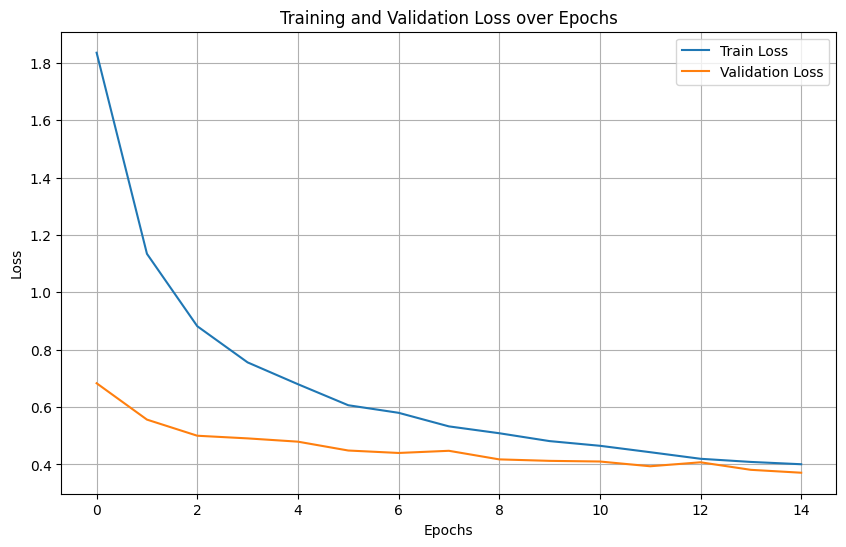

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
## Test the accuracy, precision and recall for the trained model

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

def evaluate_model(model, X_test, Y_test):

    logits = model.forward(X_test, training=False)

    y_pred = np.argmax(logits, axis=1)

    y_true = Y_test

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    report = classification_report(y_true, y_pred, digits=4)

    cm = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, report, cm



In [ ]:
class MyModel:
    def __init__(self):
        self.layer1 = layer1
        self.dropout1 = dropout1
        self.relu1 = relu1
        self.layer2 = layer2
        self.dropout2 = dropout2
        self.relu2 = relu2
        self.layer3 = layer3

    def forward(self, x, training=True):
        out = self.layer1.forward(x)
        out = self.relu1.forward(out)
        if training:
            out = self.dropout1.forward(out)

        out = self.layer2.forward(out)
        out = self.relu2.forward(out)
        if training:
            out = self.dropout2.forward(out)

        out = self.layer3.forward(out)

        # Softmax for classification
        exp = np.exp(out - np.max(out, axis=1, keepdims=True))
        softmax_out = exp / np.sum(exp, axis=1, keepdims=True)

        return softmax_out


In [ ]:
model = MyModel()

accuracy, precision, recall, report, cm = evaluate_model(model, X_test, Y_test)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Classification Report:\n", report)
print("Confusion Matrix:\n", cm)

Accuracy: 0.9345
Precision: 0.9344
Recall: 0.9345
Classification Report:
               precision    recall  f1-score   support

           0     0.9387    0.9847    0.9612       980
           1     0.9695    0.9806    0.9750      1135
           2     0.9407    0.9225    0.9315      1032
           3     0.9172    0.9327    0.9249      1010
           4     0.9138    0.9389    0.9262       982
           5     0.9326    0.8845    0.9079       892
           6     0.9378    0.9593    0.9484       958
           7     0.9404    0.9377    0.9391      1027
           8     0.9214    0.8901    0.9055       974
           9     0.9268    0.9039    0.9152      1009

    accuracy                         0.9345      9999
   macro avg     0.9339    0.9335    0.9335      9999
weighted avg     0.9344    0.9345    0.9343      9999

Confusion Matrix:
 [[ 965    0    1    1    0    3    6    2    2    0]
 [   0 1113    3    4    1    0    3    2    9    0]
 [   8    6  952   10   10    0    9   12 